In [30]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib import rcParams, pyplot as plt

tfd = tfp.distributions
tfb = tfp.bijectors

rcParams['figure.figsize'] = [12, 8]
rcParams['figure.dpi'] = 200

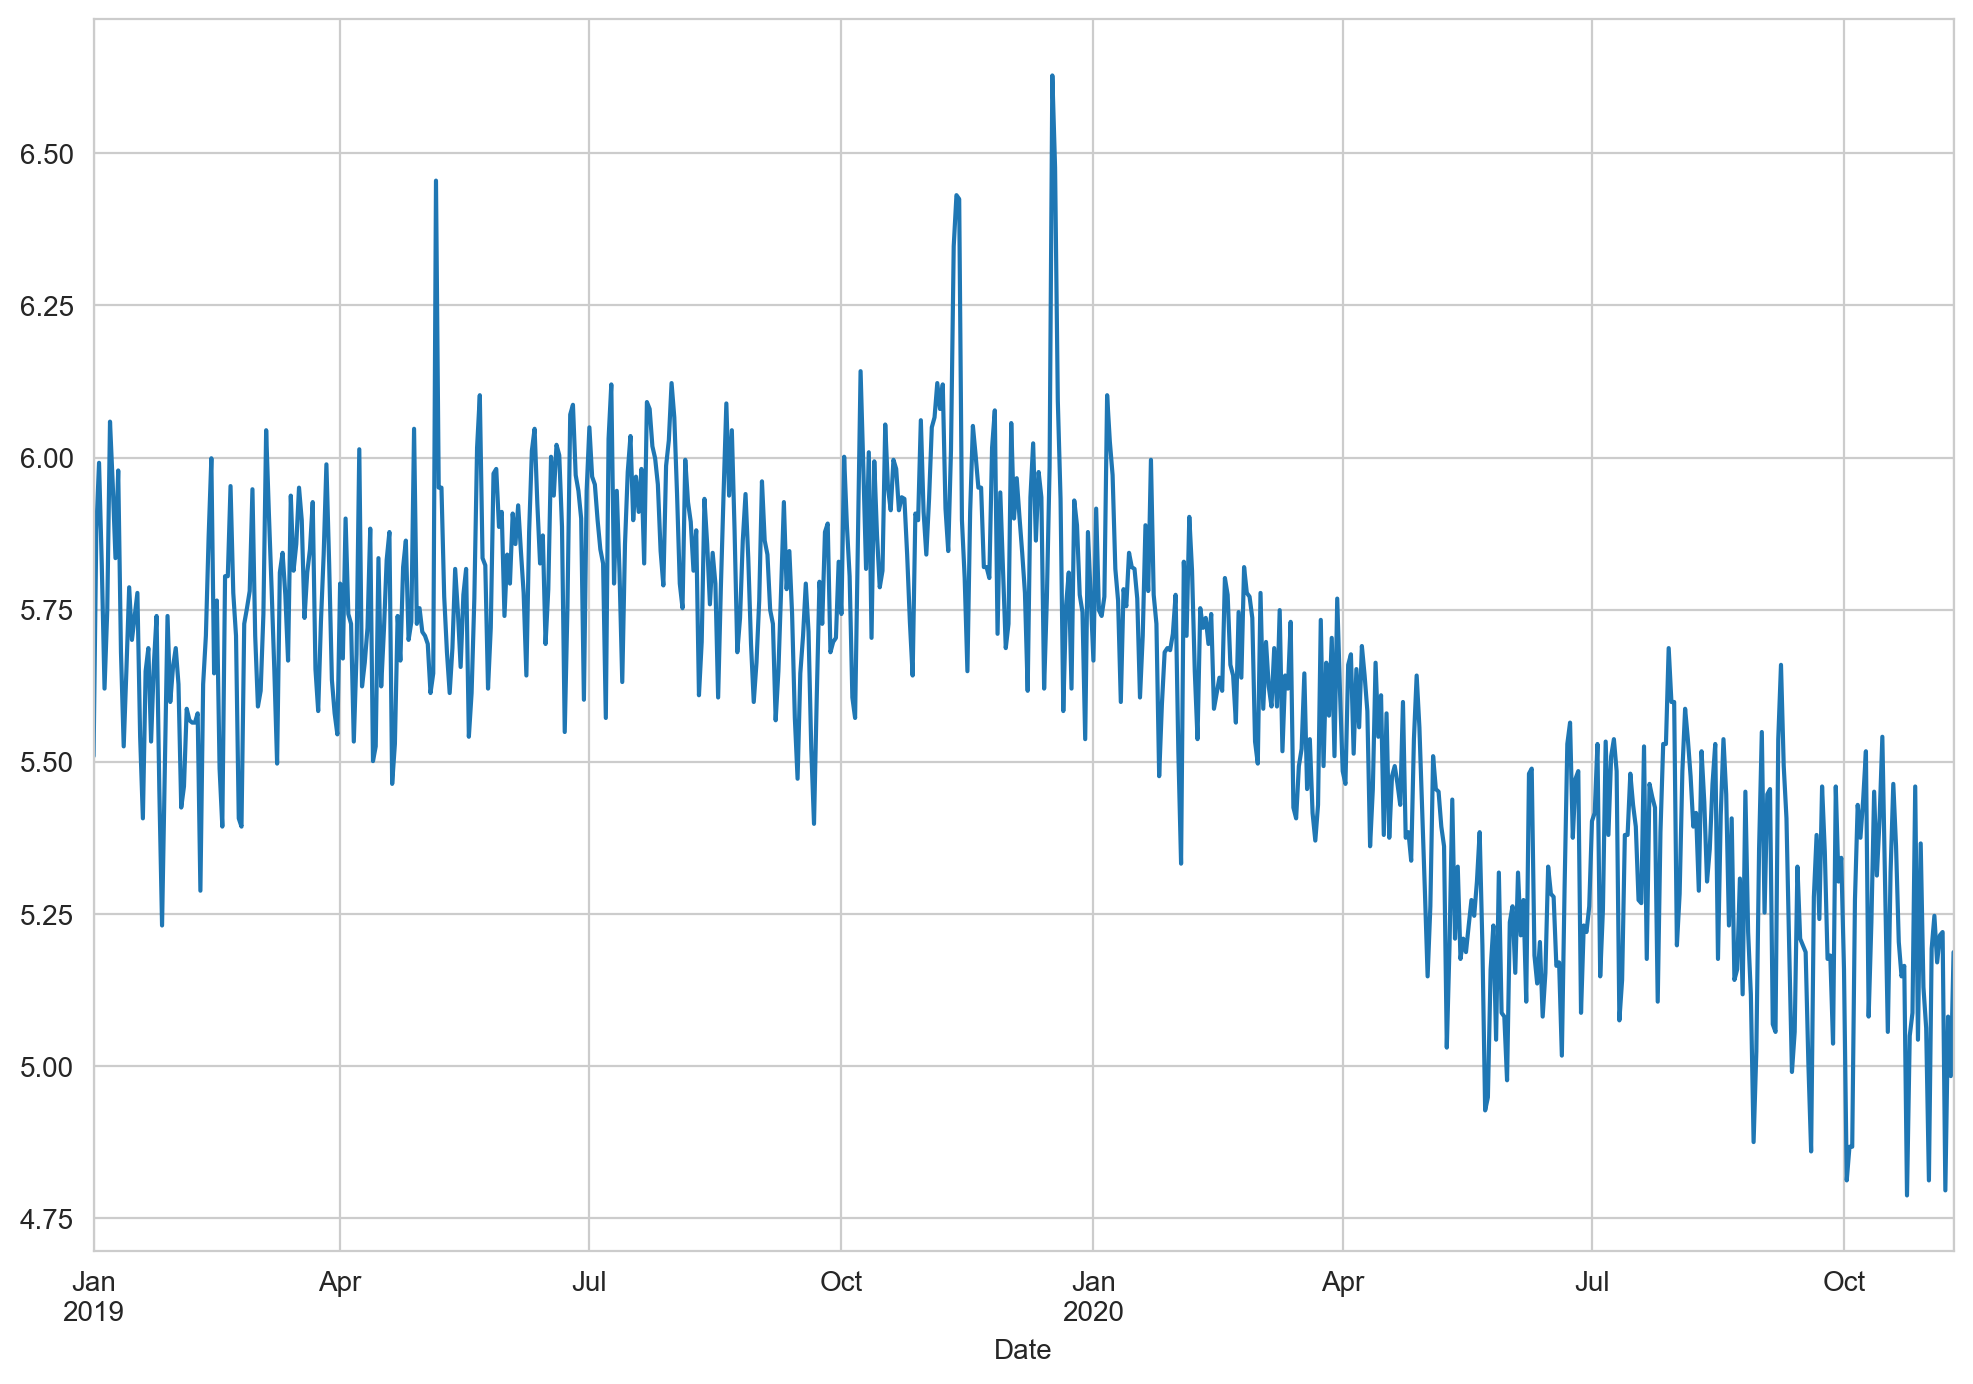

In [16]:
data = pd.read_csv('data/pageviews-20190101-20201110.csv',
                   index_col='Date',
                   parse_dates=['Date'],
                   dtype={'Vacation': float})
data.index.freq = 'D'
data['LogVacation'] = np.log(data['Vacation'])
_ = data['LogVacation'].plot()

In [23]:
data_tensor = tf.convert_to_tensor(data['LogVacation'].to_numpy(), dtype=tf.float32)
data_index = data.index

In [24]:
def vacation_count_model(vacation_rate_fn):
    return tfd.JointDistributionNamed(dict(
        e=tfd.Exponential(rate=1.),
        l=tfd.Exponential(rate=1.),
        s=tfd.Uniform(0., high=len(data_index)),
        d_t=lambda s, l, e: tfd.Independent(
            tfd.Poisson(rate=vacation_rate_fn(np.arange(len(data_index)), s, l, e)),
            reinterpreted_batch_ndims=1)
        )
    )

def vacation_rate_switch(ys, s, l, e):
  return tf.where(ys < s, e, l)

def vacation_rate_sigmoid(ys, s, l, e):
  return e + tf.sigmoid(ys - s) * (l - e)

model_switch = vacation_count_model(vacation_rate_switch)
model_sigmoid = vacation_count_model(vacation_rate_sigmoid)

In [25]:
def target_log_prob_fn(model, s, e, l):
  return model.log_prob(s=s, e=e, l=l, d_t=data_tensor)

models = [model_switch, model_sigmoid]
print([target_log_prob_fn(m, 40., 3., .9).numpy() for m in models])  # Somewhat likely result
print([target_log_prob_fn(m, 60., 1., 5.).numpy() for m in models])  # Rather unlikely result
print([target_log_prob_fn(m, -10., 1., 1.).numpy() for m in models]) # Impossible result

[-4851.3438, -4844.709]
[-1573.2362, -1568.2694]
[-inf, -inf]


In [43]:
num_results = 10000000
num_burnin_steps = 0

@tf.function(autograph=False, experimental_compile=True)
def make_chain(target_log_prob_fn):
   kernel = tfp.mcmc.TransformedTransitionKernel(
       inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
          target_log_prob_fn=target_log_prob_fn,
          step_size=0.05,
          num_leapfrog_steps=3),
       bijector=[
          tfb.Sigmoid(low=0., high=tf.cast(len(data_index), dtype=tf.float32)),
          tfb.Softplus(),
          tfb.Softplus(),
      ])
   kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=kernel,
        num_adaptation_steps=int(0.8*num_burnin_steps))

   states = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=[
          # The three latent variables
          tf.ones([], name='init_switchpoint'),
          tf.ones([], name='init_pre_covid_rate'),
          tf.ones([], name='init_post_covid_rate'),
      ],
      trace_fn=None,
      kernel=kernel)
   return states

with tf.device('CPU:0'):
    switch_samples = [s.numpy() for s in make_chain(lambda *args: target_log_prob_fn(model_switch, *args))]
    sigmoid_samples = [s.numpy() for s in make_chain(lambda *args: target_log_prob_fn(model_sigmoid, *args))]

switchpoint, pre_covid_rate, post_covid_rate = zip(switch_samples, sigmoid_samples)

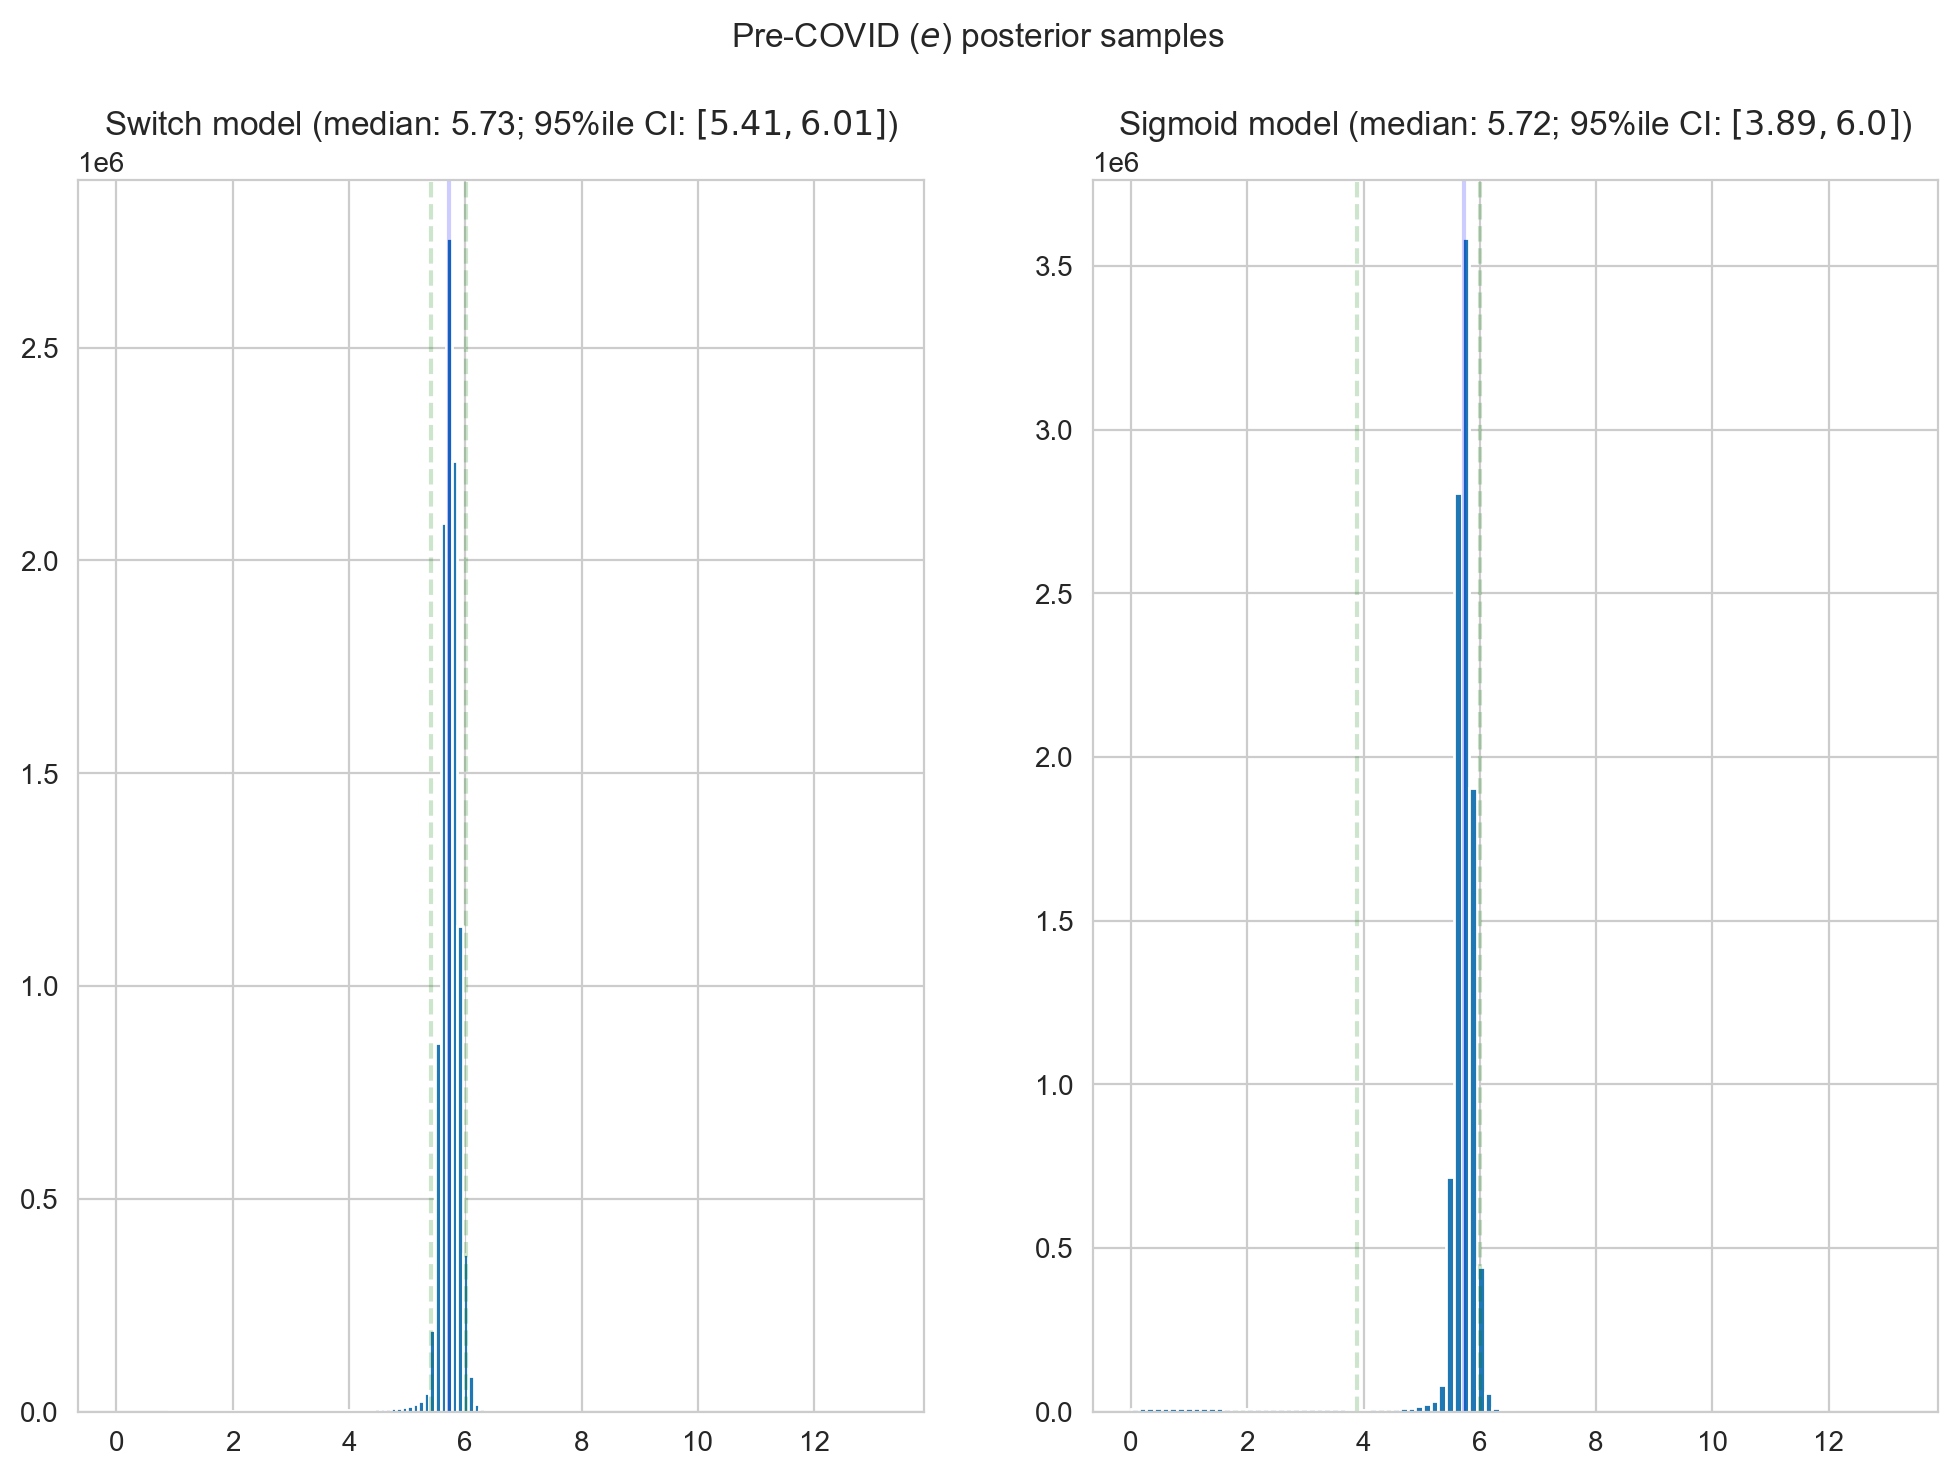

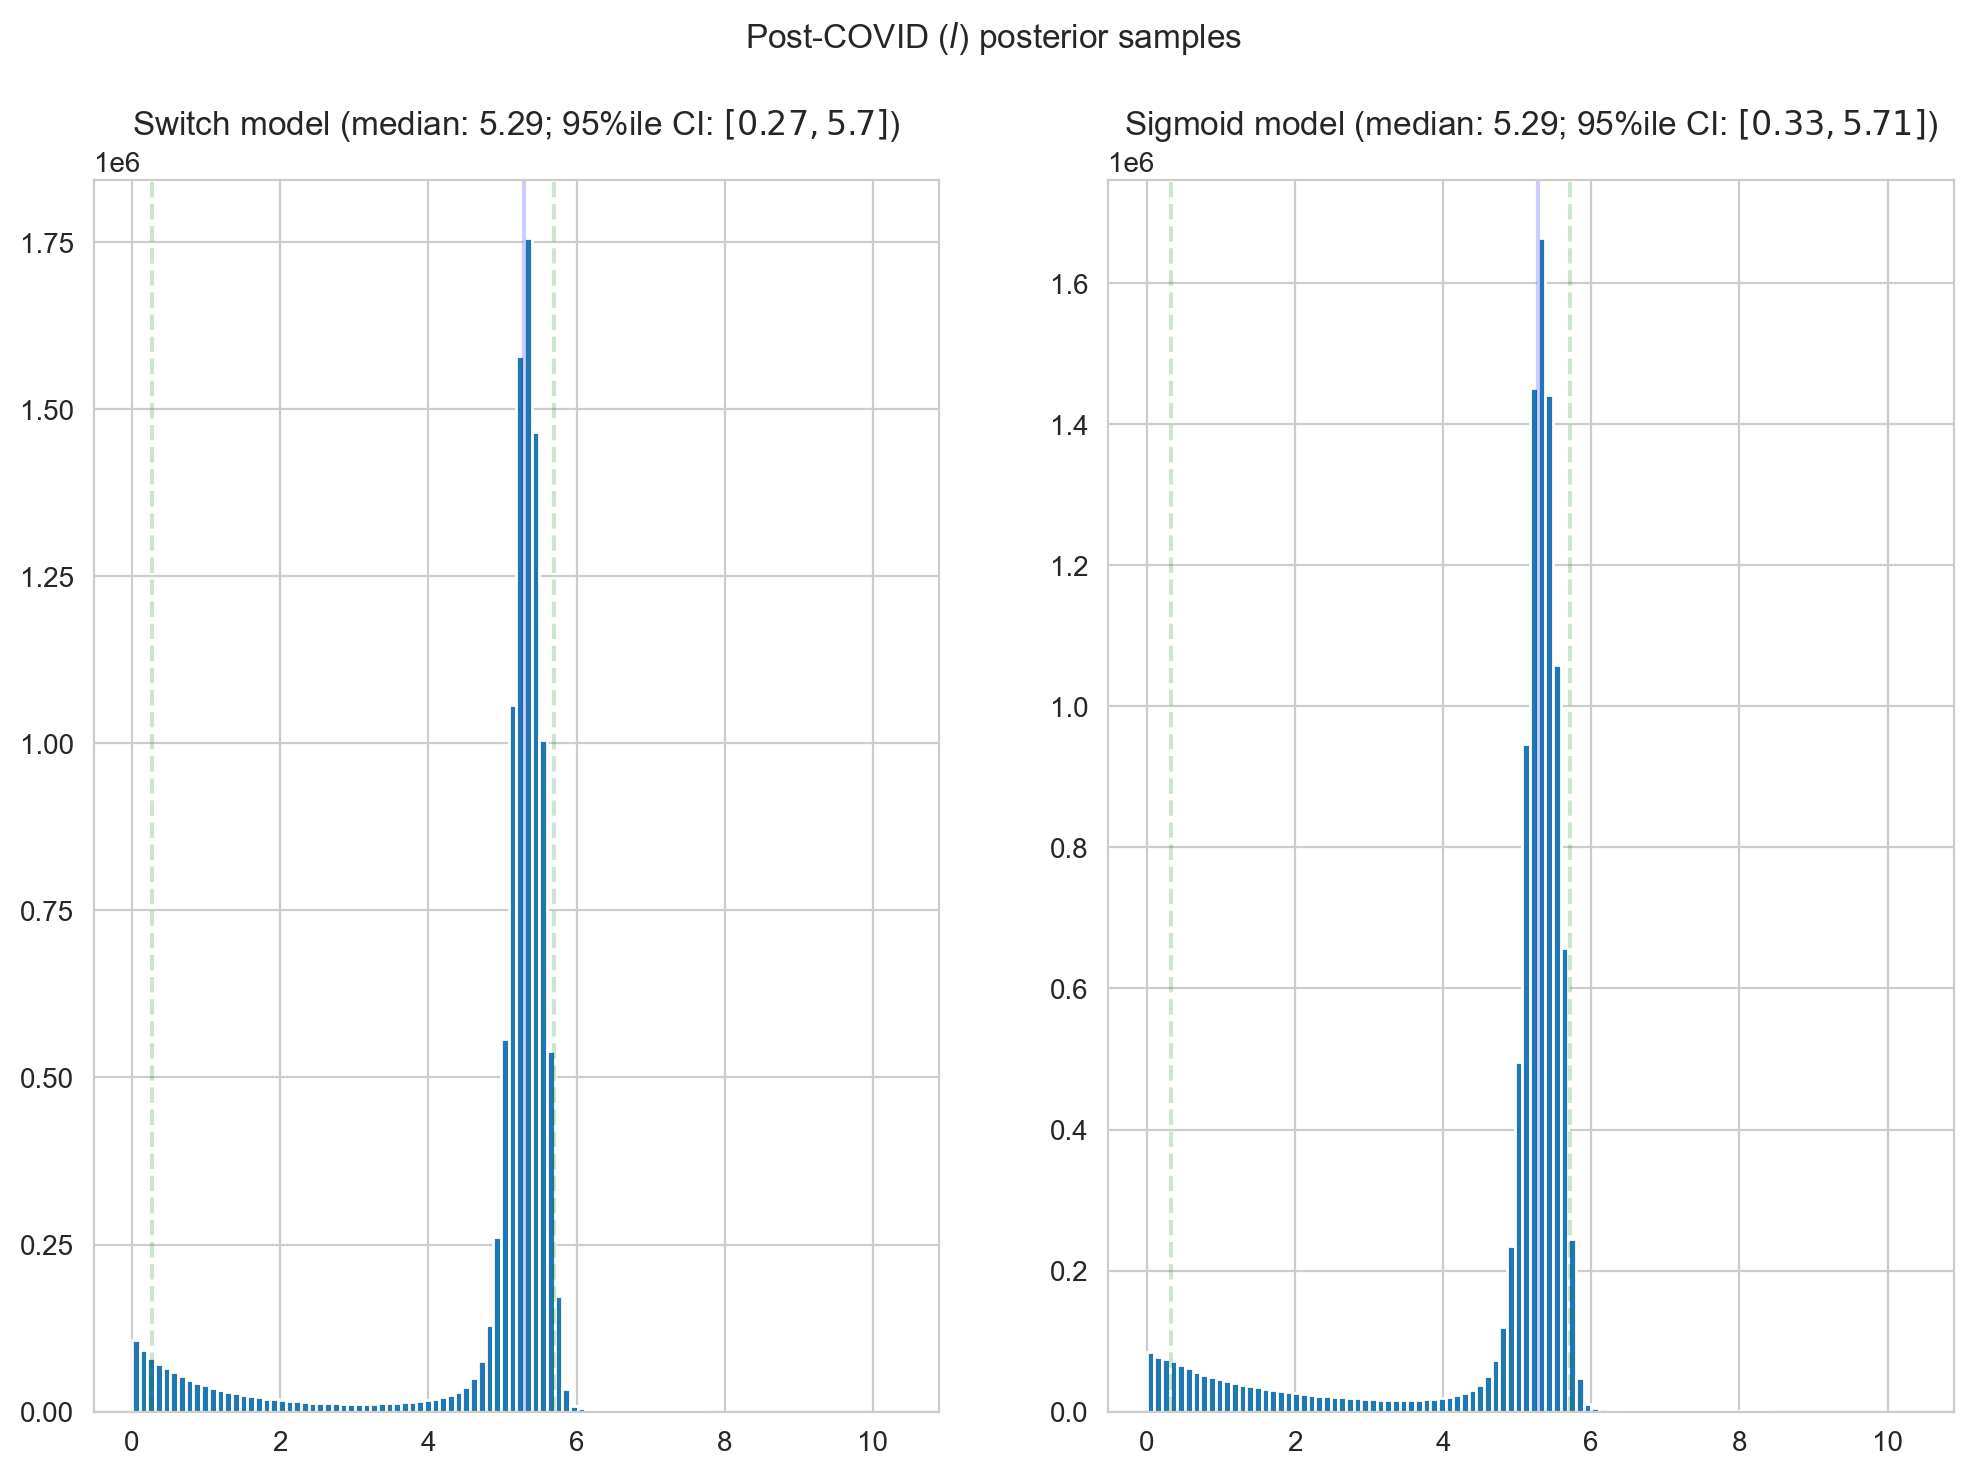

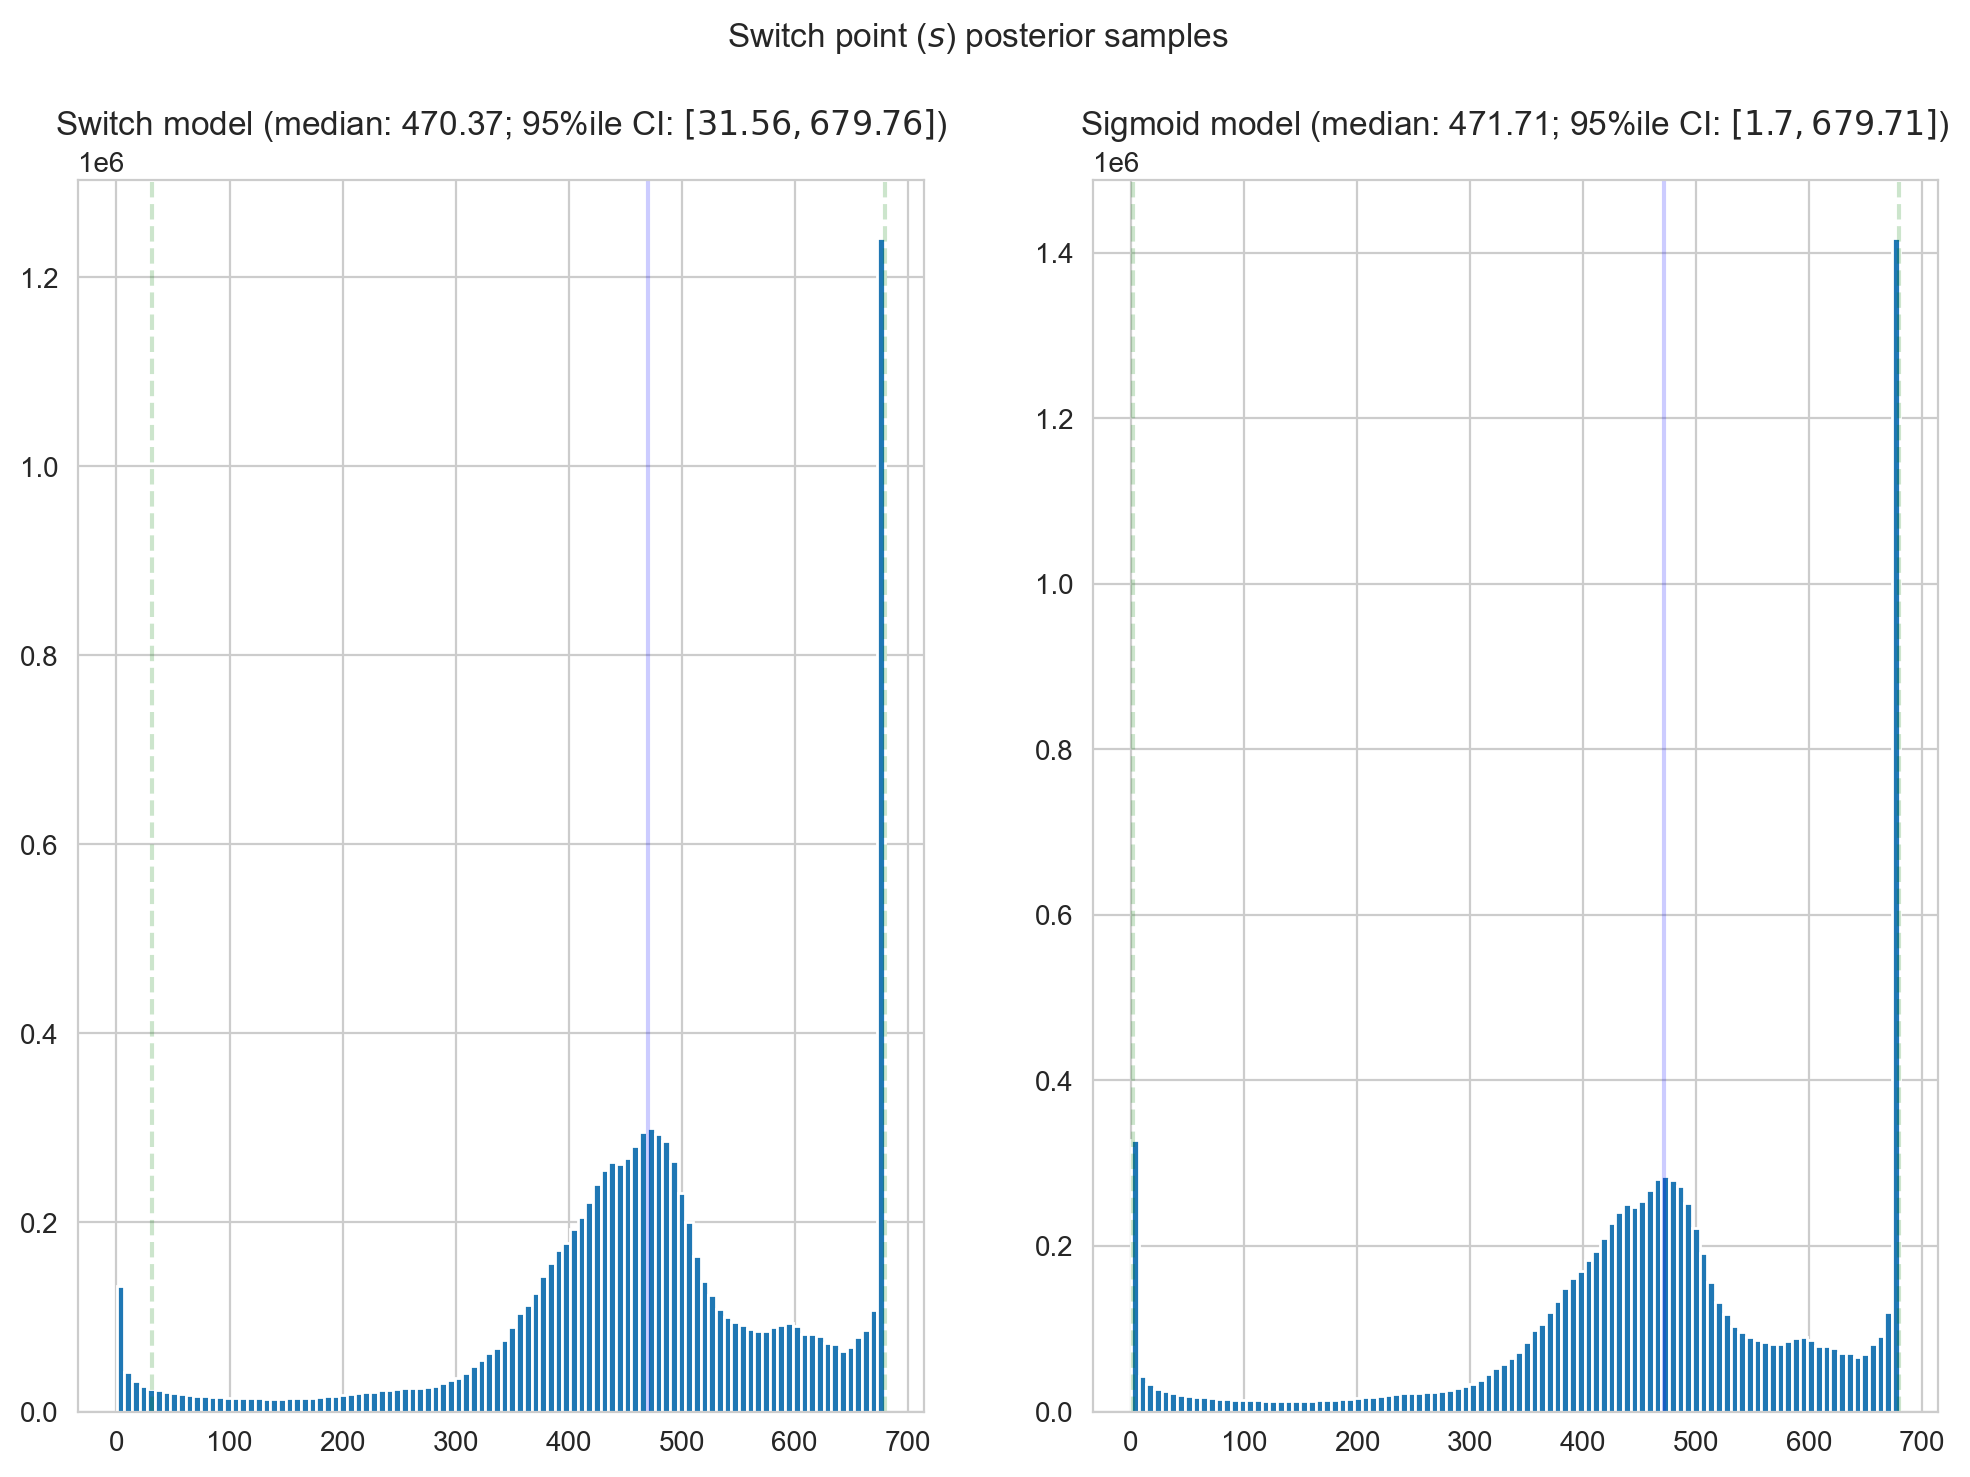

In [47]:
def _desc(v):
  return '(median: {}; 95%ile CI: $[{}, {}]$)'.format(
      *np.round(np.percentile(v, [50, 2.5, 97.5]), 2))

for t, v in [
    ('Pre-COVID ($e$) posterior samples', pre_covid_rate),
    ('Post-COVID ($l$) posterior samples', post_covid_rate),
    ('Switch point ($s$) posterior samples', switchpoint),
]:
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex='all', figsize=(12,8))
    for (m, i) in (('Switch', 0), ('Sigmoid', 1)):
        a = ax[i]
        a.hist(v[i], bins=100)
        a.axvline(x=np.percentile(v[i], 50), color='blue', alpha=.2)
        a.axvline(x=np.percentile(v[i], 2.5), color='green', ls='dashed', alpha=.2)
        a.axvline(x=np.percentile(v[i], 97.5), color='green', ls='dashed', alpha=.2)
        a.set_title(m + ' model ' + _desc(v[i]))
    fig.suptitle(t)
    plt.show()